# Spectral Analysis for Zabuyelite

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
from tqdm import tqdm
import swordfish as sf
from WIMpy import DMUtils as DMU
from scipy.interpolate import interp1d

# rc('text', usetex=True)
# rc('font',**{'family':'sans-serif','sans-serif':['cmr']})
# rc('font',**{'family':'serif','serif':['cmr']})
%matplotlib inline

Not totally sure how to calculate the rate here. I'm going to assume that the rate for a target with multiple nuclei is given by

$$ \frac{dR}{dE} = \sum_i A_i\frac{dR_i}{dE}$$

where $i$ refers to the different nuclei and $A_i$ is their by mass contribution to the total nuclei. I'll therefore calculate the spectra as a function of track length with 

$$ \frac{dR}{dx} = \sum_i A_i\frac{dR_i}{dE}\frac{dE}{dx_i}$$

where the $dR/dx_i$ refers to the differential track length from scattering off a particular nuclei.

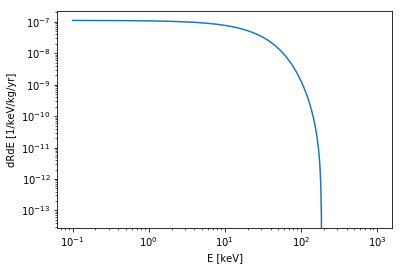

In [63]:
# Zabuyelite is Li2CO3 therefore we need to some over several elements to get the signal
# Here we give the number of protons and neutrons in lithium, carbon, and oxygen
# in that order
nuclei_Zab = ["Li", "C", "O"]
Zab_abun = np.array([0.189,0.162,0.649])
Zab_p = np.array([3,6,8])
Zab_n = np.array([4,6,8])

def dRdE_Zab(E, sigma, m):
    # E in keV, sigma in cm^2, mass in GeV
    dRdE = np.zeros_like(E)
    for i, ratio in enumerate(Zab_abun):
        dRdE += ratio*DMU.dRdE_standard(E, Zab_p[i], Zab_n[i], m, sigma)
    return dRdE

E_list = np.logspace(-1, 3, 500) # keV
dRdE = dRdE_Zab(E_list, 1e-45, 500)
plt.loglog(E_list,dRdE)
plt.ylabel("dRdE [1/keV/kg/yr]")
plt.xlabel("E [keV]")
plt.show()

Now we need to know the spectra as a function of track length, I'll use the SRIM code and load in the tables

In [64]:
#NB: The interpolation function had the same name as "dEdx_Li" as the data you were loading in
#I've renamed the arrays to dEdx_data_Li (etc.), to clear this up...

E_Li, dEedx_Li, dEdx_data_Li, x_Li = np.loadtxt("../Data/dRdESRIM/Li-Zab-CC2338.txt", usecols=(0,1,2,3), unpack=True)
E_C, dEedx_C, dEdx_data_C, x_C = np.loadtxt("../Data/dRdESRIM/C-Zab-CC2338.txt", usecols=(0,1,2,3), unpack=True)
E_O, dEedx_O, dEdx_data_O, x_O = np.loadtxt("../Data/dRdESRIM/O-Zab-CC2338.txt", usecols=(0,1,2,3), unpack=True)

x_Li *= 1.e3 # Convert micro_m to nm
x_C *= 1.e3 # Convert micro_m to nm
x_O *= 1.e3 # Convert micro_m to nm

# Add electronic stopping to nuclear stopping
dEdx_data_Li += dEedx_Li 
dEdx_data_C += dEedx_C 
dEdx_data_O += dEedx_O 

dEdx_data_Li *= 1.e-3 # Convert keV/micro_m to keV/nm
dEdx_data_C *= 1.e-3 # Convert keV/micro_m to keV/nm
dEdx_data_O *= 1.e-3 # Convert keV/micro_m to keV/nm

Etox_Li = interp1d(E_Li, x_Li, bounds_error=False, fill_value='extrapolate')
Etox_C = interp1d(E_C, x_C, bounds_error=False, fill_value='extrapolate')
Etox_O = interp1d(E_O, x_O, bounds_error=False, fill_value='extrapolate')

dEdx_Li = interp1d(x_Li, dEdx_data_Li, bounds_error=False, fill_value='extrapolate')
dEdx_C = interp1d(x_C, dEdx_data_C, bounds_error=False, fill_value='extrapolate')
dEdx_O = interp1d(x_O, dEdx_data_O, bounds_error=False, fill_value='extrapolate')

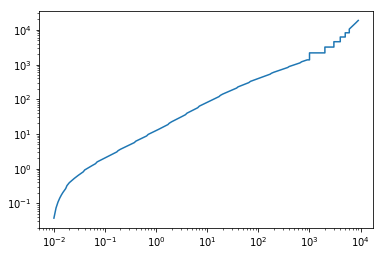

In [77]:
from scipy.integrate import cumtrapz
dist = cumtrapz(1/dEdx_data_Li,x=E_Li)
plt.loglog(E_Li[:-1],dist)

/usr/local/lib/python3.6/site-packages/scipy/interpolate/interpolate.py:610: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/usr/local/lib/python3.6/site-packages/scipy/interpolate/interpolate.py:613: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


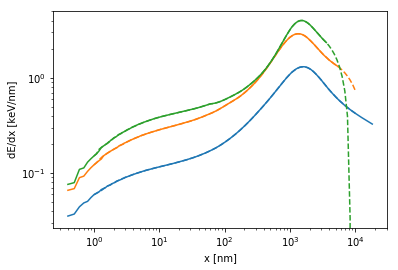

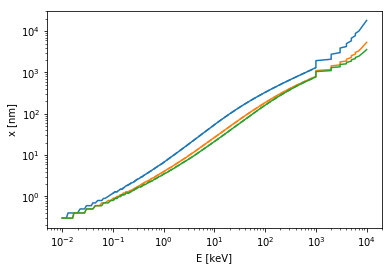

In [65]:
x_list = np.logspace(0,4,100)

plt.figure()
plt.loglog(x_Li, dEdx_Li(x_Li), color='C0')
plt.loglog(x_list, dEdx_Li(x_list), ls='--', color='C0')

plt.loglog(x_C, dEdx_C(x_C), color='C1')
plt.loglog(x_list, dEdx_C(x_list), ls='--', color='C1')

plt.loglog(x_O, dEdx_O(x_O), color='C2')
plt.loglog(x_list, dEdx_O(x_list), ls='--', color='C2')

plt.ylabel("dE/dx [keV/nm]")
plt.xlabel("x [nm]")
plt.show()

plt.figure()
plt.loglog(E_Li, x_Li, color='C0')
plt.loglog(E_list, Etox_Li(E_list), ls='--', color='C0')

plt.loglog(E_C, x_C, color='C1')
plt.loglog(E_list, Etox_C(E_list), ls='--', color='C1')

plt.loglog(E_O, x_O, color='C2')
plt.loglog(E_list, Etox_O(E_list), ls='--', color='C2')

plt.ylabel("x [nm]")
plt.xlabel("E [keV]")
plt.show()

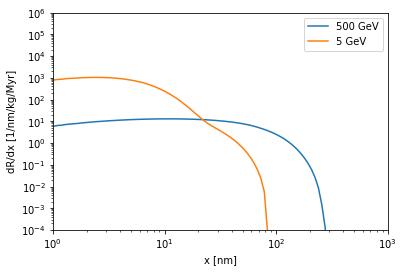

In [66]:
x_bins = np.logspace(0,3,100)
x_width = np.diff(x_bins)
x_c = x_bins[:-1] + x_width/2

dEdxZab = [dEdx_Li,dEdx_C,dEdx_O]
EtoxZab = [Etox_Li,Etox_C,Etox_O]

dEdx_nuclei_Zab = dict(zip(nuclei_Zab, dEdxZab))
Etox_nuclei_Zab = dict(zip(nuclei_Zab, EtoxZab))
ratio_nuclei_Zab = dict(zip(nuclei_Zab, Zab_abun))


def dRdx_Zab(x, E, sigma, m):
    # E in keV, sigma in cm^2, mass in GeV
    dRdx = np.zeros_like(x)
    for i, nuc in enumerate(nuclei_Zab):
        xtemp = Etox_nuclei_Zab[nuc](E)
        dRdx_nuc = DMU.dRdE_standard(E, Zab_p[i], Zab_n[i], m, sigma)*dEdx_nuclei_Zab[nuc](xtemp)
        temp_interp = interp1d(xtemp, dRdx_nuc, bounds_error=False, fill_value='extrapolate')
#         plt.loglog(x,temp_interp(x), label=nuc)
        dRdx += ratio_nuclei_Zab[nuc]*temp_interp(x)
    return dRdx
        
dRdx_Zab500 = dRdx_Zab(x_c, E_list, 1e-45, 500)
dRdx_Zab5 = dRdx_Zab(x_c, E_list, 1e-45, 5)
plt.loglog(x_c, dRdx_Zab500*1e6*365, label="500 GeV")
plt.loglog(x_c, dRdx_Zab5*1e6*365, label="5 GeV")
plt.legend()
plt.ylabel("dR/dx [1/nm/kg/Myr]")
plt.xlabel("x [nm]")
plt.ylim(1e-4,1e6)
plt.xlim(1,1000)
plt.show()

# Now lets do Sylvanite

In [40]:
# Sylvanite is Au.75Ag.25Te2 therefore we need to some over several elements to get the signal
# Here we give the number of protons and neutrons in Gold, Silver, and Te
# in that order
nuclei_Syl = ["Au", "Ag", "Te"]
Syl_abun = np.array([0.343,0.0627,0.5936])
Syl_p = np.array([79,47,52])
Syl_n = np.array([118,61,76])

In [41]:
#Check the mass fractions:

In [42]:
Syl_A = Syl_p + Syl_n
stoich = np.array([0.75, 0.25, 2])
Syl_abun = Syl_A*stoich/np.sum(Syl_A)
print(Syl_abun)

[0.34122402 0.06235566 0.59122402]


In [43]:
#NB: The interpolation function had the same name as "dEdx_Au" as the data you were loading in
#I've renamed the arrays to dEdx_data_Au (etc.), to clear things up...
E_Au, dEedx_Au, dEdx_data_Au, x_Au = np.loadtxt("../Data/dRdESRIM/Au-Syl-CC1.txt", usecols=(0,1,2,3), unpack=True)
E_Ag, dEedx_Ag, dEdx_data_Ag, x_Ag = np.loadtxt("../Data/dRdESRIM/Ag-Syl-CC1.txt", usecols=(0,1,2,3), unpack=True)
E_Te, dEedx_Te, dEdx_data_Te, x_Te = np.loadtxt("../Data/dRdESRIM/Te-Syl-CC1.txt", usecols=(0,1,2,3), unpack=True)

x_Au *= 1.e3 # Convert micro_m to nm
x_Ag *= 1.e3 # Convert micro_m to nm
x_Te *= 1.e3 # Convert micro_m to nm

dEdx_data_Au += dEedx_Au
dEdx_data_Ag += dEedx_Ag
dEdx_data_Te += dEedx_Te

dEdx_data_Au *= 1.e-3 # Convert keV/micro_m to keV/nm
dEdx_data_Ag *= 1.e-3 # Convert keV/micro_m to keV/nm
dEdx_data_Te *= 1.e-3 # Convert keV/micro_m to keV/nm

Etox_Au = interp1d(E_Au, x_Au, fill_value='extrapolate')
Etox_Ag = interp1d(E_Ag, x_Ag, fill_value='extrapolate')
Etox_Te = interp1d(E_Te, x_Te, fill_value='extrapolate')

dEdx_Au = interp1d(x_Au, dEdx_data_Au, fill_value='extrapolate')
dEdx_Ag = interp1d(x_Ag, dEdx_data_Ag, fill_value='extrapolate')
dEdx_Te = interp1d(x_Te, dEdx_data_Te, fill_value='extrapolate')

xtoE_Au = interp1d(x_Au, E_Au, fill_value='extrapolate')
xtoE_Ag = interp1d(x_Ag, E_Ag, fill_value='extrapolate')
xtoE_Te = interp1d(x_Te, E_Te, fill_value='extrapolate')

Plot stopping power and track lengths

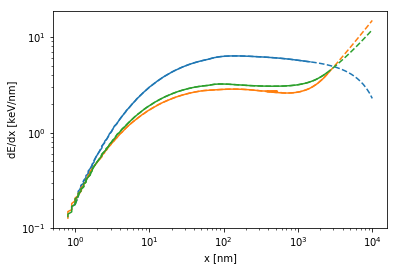

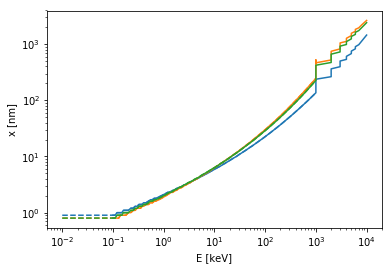

In [44]:
plt.figure()
plt.loglog(x_Au, dEdx_data_Au,color='C0')
plt.loglog(x_list, dEdx_Au(x_list),color='C0', linestyle='--')

plt.loglog(x_Ag, dEdx_data_Ag,color='C1')
plt.loglog(x_list, dEdx_Ag(x_list),color='C1', linestyle='--')

plt.loglog(x_Te, dEdx_data_Te,color='C2')
plt.loglog(x_list, dEdx_Te(x_list),color='C2', linestyle='--')

plt.ylabel("dE/dx [keV/nm]")
plt.xlabel("x [nm]")
plt.show()


plt.figure()

plt.loglog(E_Au, x_Au,color='C0')
plt.loglog(E_list, Etox_Au(E_list), linestyle='--',color='C0')

plt.loglog(E_Ag, x_Ag, color='C1')
plt.loglog(E_list, Etox_Ag(E_list), linestyle='--',color='C1')

plt.loglog(E_Te, x_Te, color='C2')
plt.loglog(E_list, Etox_Te(E_list), linestyle='--',color='C2')


plt.xlabel("E [keV]")
plt.ylabel("x [nm]")
plt.show()


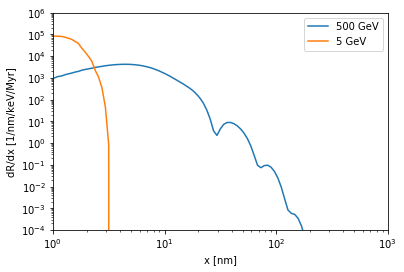

In [46]:
dEdx_Syl = [dEdx_Au,dEdx_Ag,dEdx_Te]
Etox_Syl = [Etox_Au,Etox_Ag,Etox_Te]
xtoE_Syl = [xtoE_Au,xtoE_Ag,xtoE_Te]

dEdx_nuclei_Syl = dict(zip(nuclei_Syl, dEdx_Syl))
Etox_nuclei_Syl = dict(zip(nuclei_Syl, Etox_Syl))
xtoE_nuclei_Syl = dict(zip(nuclei_Syl, xtoE_Syl))

ratio_nuclei_Syl = dict(zip(nuclei_Syl, Syl_abun))

# def dRdx_Syl(x, E, sigma, m):
#     # E in keV, sigma in cm^2, mass in GeV
#     dRdx = np.zeros_like(x)
#     for i, nuc in enumerate(nuclei_Syl):
#         xtemp = Etox_nuclei_Syl[nuc](E)
#         dRdx_nuc = DMU.dRdE_standard(E, Syl_p[i], Syl_n[i], m, sigma)*dEdx_nuclei_Syl[nuc](xtemp)
#         temp_interp = interp1d(xtemp, dRdx_nuc, fill_value='extrapolate')
#         dRdx += ratio_nuclei_Syl[nuc]*temp_interp(x)
#     return dRdx

def dRdx_Syl(x, sigma, m):
    # E in keV, sigma in cm^2, mass in GeV
    dRdx = np.zeros_like(x)
    for i, nuc in enumerate(nuclei_Syl):
        Etemp = xtoE_nuclei_Syl[nuc](x)
        dRdx_nuc = DMU.dRdE_standard(Etemp, Syl_p[i], Syl_n[i], m, sigma)*dEdx_nuclei_Syl[nuc](x)
        #temp_interp = interp1d(xtemp, dRdx_nuc, fill_value='extrapolate')
        dRdx += ratio_nuclei_Syl[nuc]*dRdx_nuc
    return dRdx
    
#NB: There was a missing factor of 365 to go from (per day) -> (per year)
    
dRdx_Syl500 = dRdx_Syl(x_c, 1e-45, 500)
dRdx_Syl5 = dRdx_Syl(x_c, 1e-45, 5)
# dRdx_Syl500 = dRdx_Syl(x_c, E_list,1e-45, 500)
# dRdx_Syl5 = dRdx_Syl(x_c, E_list,1e-45, 5)
plt.loglog(x_c, dRdx_Syl500*1e6*365, label="500 GeV")
plt.loglog(x_c, dRdx_Syl5*1e6*365, label="5 GeV")
plt.legend()
plt.ylabel("dR/dx [1/nm/keV/Myr]")
plt.xlabel("x [nm]")
plt.ylim(1e-4,1e6)
plt.xlim(1,1000)
plt.show()